# Training LayoutLM-v3 model on Invoice Dataset

This Notebook is inspired from Mr.Niels Rogge [notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/LayoutLMv3/Fine_tune_LayoutLMv3_on_FUNSD_(HuggingFace_Trainer).ipynb) for training LayoutLMv3 model from scratch.


This notebook is divided into three part namely:

1. Training
2. Testing
3. Inference on Gradio

Gradio Demo of LayoutLM v3 is  deployed at Huggingface spaces and is  available from the [notebook](https://huggingface.co/spaces/Theivaprakasham/layoutlmv3_invoice): https://huggingface.co/spaces/Theivaprakasham/layoutlmv3_invoice


Please do support with a like if you enjoy reading through the notebook or the demo.

Thank you Folks.

In [1]:
import pandas as pd
from datasets import load_dataset, Dataset


train_path = "./data/processed/training/sample3.json"
valid_path = "./data/processed/validation/sample2.json"
test_path = "./data/processed/test/sample5.json"

df_train = pd.read_json(train_path)
df_validation = pd.read_json(valid_path)
df_test = pd.read_json(test_path)

In [2]:
import ast
num = 0
for index, bbox in enumerate(df_train['bboxes'][0]):
    df_train['bboxes'][0][index] = ast.literal_eval(bbox)


for index, bbox in enumerate(df_validation['bboxes'][0]):
    df_validation['bboxes'][0][index] = ast.literal_eval(bbox)

    
for index, bbox in enumerate(df_test['bboxes'][0]):
    df_test['bboxes'][0][index] = ast.literal_eval(bbox)

In [3]:
df_train['bboxes'][0][0]

[430, 67, 509, 87]

In [4]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

features = Features({
    'image_name' : Value(dtype='string', id=None),
    'words' : Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
    'bboxes' : Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
    'labels' : Sequence(feature=ClassLabel(num_classes=5, names=["clientName", "bankinfo", "paymentDueDate", "total", "others"], id=None), length=-1, id=None),
    '__index_level_0__' : Value(dtype='int64', id=None)
    
})

In [5]:
dataset_train = Dataset.from_pandas(df_train, features=features)
dataset_valid = Dataset.from_pandas(df_validation, features=features)
dataset_test = Dataset.from_pandas(df_test, features=features)

In [6]:
dataset_train

Dataset({
    features: ['image_name', 'words', 'bboxes', 'labels', '__index_level_0__'],
    num_rows: 1
})

In [7]:
example = dataset_train[0]
print(example)

{'image_name': 'sample3_image_0.jpeg', 'words': ['請求', '書', 'サンプル', '産業', '株式会社', '御', '中', '請求', 'No.', 'ご', '担当', ':', '請求', 'さ', 'れ', '太郎', '様', '請求', '日', '件名', ':', '2020', '年', '10', '月', 'サービス', '利用', '料', '下記', 'の', '通り', '、', 'ご', '請求', '申し上げ', 'ます', '。', '株式会社', '前', '月末', '払', 'ンボ株', ')', '〒123-4567', 'it', '東京', '都', '新宿', '区', '新宿', 'りごと', '3', '新宿', '第', '1', 'ビル', '2', '階', 'EP', 'サ', '社', 'TEL', ':', '03-0000-0000', 'FAX', ':', '03-0000-0000', 'E', '-', 'Mail', ':', 'sample', '@', 'sample', ',', 'com', '担当', ':', 'サービス', 'し', '太郎', '合計', '金額', '¥', '330,000', '(', '税', '込', ')', 'お', '支払', '期限', ':', '2020/9/30', '摘要', '数量', '単', '価', '金額', 'No.', '|', 'サービス', '利用', '料', '1', '300,000', '¥', '300,000', '小', '計', '消費', '税', '合計', '¥', '300,000', '¥', '30,000', '¥', '330,000', 'お', '振込', '先', 'サンプル', '銀行', 'サンプル', '支店', '普通', '0123456', 'サンプル', '(', 'カ', '備考'], 'bboxes': [[430, 67, 509, 87], [541, 67, 564, 87], [114, 112, 206, 130], [211, 112, 250, 130], [260, 112, 357, 1

In [8]:
words, bboxes, labels = example["words"], example["bboxes"], example["labels"]
print(words[0])
print(bboxes[0][0])

請求
430


In [9]:
from transformers import AutoProcessor

# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

2024-01-09 20:56:38.807093: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-09 20:56:38.840674: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-09 20:56:38.840708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-09 20:56:38.841689: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-09 20:56:38.846951: I tensorflow/core/platform/cpu_feature_guar

In [10]:
from datasets.features import ClassLabel

features = dataset_train.features
column_names = dataset_train.column_names
image_column_name = "image_path"
text_column_name = "words"
boxes_column_name = "bboxes"
label_column_name = "labels"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
# def get_label_list(labels):
#     unique_labels = set()
#     for label in labels:
#         unique_labels = unique_labels | set(label)
#     label_list = list(unique_labels)
#     label_list.sort()
#     return label_list

label_list = ["clientName", "bankinfo", "paymentDueDate", "total", "others"]
id2label = {k: v for k,v in enumerate(label_list)}
label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)
type(label_list)

list

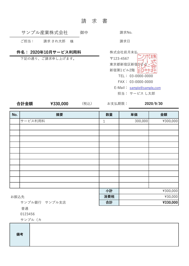

In [11]:
from PIL import Image
image = Image.open('./data/images/sample3_image_0.jpeg').convert("RGB").resize((189, 266))
image

In [14]:
import os

In [59]:
def prepare_examples(examples):
  image_dir = "./data/images/"
  image_path = [image_dir + path for path in examples['image_name']]
  print(image_path)
  images = [Image.open(path).convert('RGB').resize((196,256)) for path in image_path] #Image.open(examples[image_column_name])
  print(images)
  words = examples[text_column_name]
  print(words)
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length", max_length=197)

  return encoding

In [64]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 196, 256)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(197, 4)),
    'labels': Sequence(ClassLabel(names=label_list)),
})

train_dataset = dataset_train.map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
eval_dataset = dataset_test.map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

['./data/images/sample3_image_0.jpeg']
[<PIL.Image.Image image mode=RGB size=196x256 at 0x148A730EF390>]
[['請求', '書', 'サンプル', '産業', '株式会社', '御', '中', '請求', 'No.', 'ご', '担当', ':', '請求', 'さ', 'れ', '太郎', '様', '請求', '日', '件名', ':', '2020', '年', '10', '月', 'サービス', '利用', '料', '下記', 'の', '通り', '、', 'ご', '請求', '申し上げ', 'ます', '。', '株式会社', '前', '月末', '払', 'ンボ株', ')', '〒123-4567', 'it', '東京', '都', '新宿', '区', '新宿', 'りごと', '3', '新宿', '第', '1', 'ビル', '2', '階', 'EP', 'サ', '社', 'TEL', ':', '03-0000-0000', 'FAX', ':', '03-0000-0000', 'E', '-', 'Mail', ':', 'sample', '@', 'sample', ',', 'com', '担当', ':', 'サービス', 'し', '太郎', '合計', '金額', '¥', '330,000', '(', '税', '込', ')', 'お', '支払', '期限', ':', '2020/9/30', '摘要', '数量', '単', '価', '金額', 'No.', '|', 'サービス', '利用', '料', '1', '300,000', '¥', '300,000', '小', '計', '消費', '税', '合計', '¥', '300,000', '¥', '30,000', '¥', '330,000', 'お', '振込', '先', 'サンプル', '銀行', 'サンプル', '支店', '普通', '0123456', 'サンプル', '(', 'カ', '備考']]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

['./data/images/sample5_image_0.jpeg']
[<PIL.Image.Image image mode=RGB size=196x256 at 0x148A726BA350>]
[['いつもご利⽤いただきありがとうございます。', 'INVOICE', '株式会社デモ', '下記の通りご請求申し上げます。', '\\99,790', 'ご請求⾦額', '（税込）', '品', '番', '•', '品', '名', '数', '量', '顧問料', '(2020年9⽉分)', '振込先：みずほ銀⾏', '⻁ノ⾨⽀店（普通）0101010', 'お振込み⼿数料は御社ご負担にてお願いいたします。', 'お⽀払い期限：2020年10⽉31⽇', '請', '求', '書', '備考', '消費税', '10%', '1', '\\100,000', '⼩計', '\\10,210', '源泉税', '\\99,790', '合計⾦額', '単', '価', '⾦', '額', '\\100,000', '⼭⽥法律事務所', '\\100,000', '\\10,000']]


In [65]:
train_dataset['pixel_values']

[[[[1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
 

In [66]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

'<s> 請求 書 サンプル 産業 株式会社 御 中 請求 No. ご 担当 : 請求 さ れ 太郎 様 請求 日 件名 : 2020 年 10 月 サービス 利用 料 下記 の 通り 、 ご 請求 申し上げ ます 。 株式会社 前 月末 払 ンボ株 ) 〒123-4567 it 東京 都 新宿 区 新宿 りご</s>'

In [67]:
788/4

197.0

In [68]:
train_dataset.set_format("torch")
eval_dataset.set_format("torch")

In [69]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

<s> -100
 � 4
� 4
� 4
� -100
� -100
� -100
 � 4
� 4
� 4
 サ 0
ン -100
プ -100
ル -100
 � 0
� 0
� 0
� -100
� -100
� -100
 � 0
� 0
� 0
� -100
� -100
� -100
� -100
� -100
� -100
� -100
 � 4
� 4
� 4
  4
中 -100
 � 4
� 4
� 4
� -100
� -100
� -100
 No 4
. -100
 � 4
� 4
 � 4
� 4
� 4
� -100
� -100
 : 4
 � 4
� 4
� 4
� -100
� -100
� -100
 � 4
� 4
 � 4
� 4
 � 4
� 4
� -100
� -100
 � 4
� 4
� 4
 � 4
� 4
� 4
� -100
� -100
� -100
 � 4
� 4
� 4
  4
� -100
� 4
� -100
� -100
 : 4
 2020 4
 � 4
� 4
� 4
 10 4
 � 4
� 4
 サ 4
ー� -100
� -100
ス -100
 � 4
� 4
� 4
� -100
� -100
 � 4
� 4
� 4
  4
� -100
� 4
� -100
� -100
� -100
  4
の -100
 � 4
� 4
� 4
り -100
  4
、 -100
 � 4
� 4
 � 4
� 4
� 4
� -100
� -100
� -100
 � 4
� 4
� 4
し -100
上 -100
� -100
� -100
 � 4
� 4
す -100
  4
。 -100
 � 4
� 4
� 4
� -100
� -100
� -100
� -100
� -100
� -100
� -100
 � 4
� 4
� 4
 � 4
� 4
� -100
� -100
 � 4
� 4
� 4
  4
ン -100
� -100
� -100
� -100
� -100
 ) 4
  4
� -100
� 4
123 -100
- -100
45 -100
67 -100
 it 4
 � 4
� 4
� 4
� -100
� -100
 � 4
� 4
� 4
 

In [70]:
from datasets import load_metric

metric = load_metric("seqeval")

In [71]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [72]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [73]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="layoutlmv3-finetuned-invoice",
                                  max_steps=2000,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                #   push_to_hub=True,
                                #   push_to_hub_model_id=f"layoutlmv3-finetuned-invoice", # this is the name we'll use for our model on the hub
                                  )

In [74]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [75]:
trainer.train()

RuntimeError: The size of tensor a (193) must match the size of tensor b (197) at non-singleton dimension 1

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 50
  Batch size = 2
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:755: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning


{'epoch': 40.0,
 'eval_accuracy': 1.0,
 'eval_f1': 1.0,
 'eval_loss': 0.0012058715801686049,
 'eval_precision': 1.0,
 'eval_recall': 1.0,
 'eval_runtime': 2.2427,
 'eval_samples_per_second': 22.295,
 'eval_steps_per_second': 11.148}

In [28]:
trainer.push_to_hub()

Saving model checkpoint to layoutlmv3-finetuned-invoice
Configuration saved in layoutlmv3-finetuned-invoice/config.json
Model weights saved in layoutlmv3-finetuned-invoice/pytorch_model.bin
Feature extractor saved in layoutlmv3-finetuned-invoice/preprocessor_config.json
tokenizer config file saved in layoutlmv3-finetuned-invoice/tokenizer_config.json
Special tokens file saved in layoutlmv3-finetuned-invoice/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/480M [00:00<?, ?B/s]

Upload file runs/Jun07_04-11-18_850ddd2feefa/events.out.tfevents.1654575104.850ddd2feefa.781.0:  23%|##2      …

Upload file runs/Jun07_04-11-18_850ddd2feefa/events.out.tfevents.1654575554.850ddd2feefa.781.2: 100%|#########…

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/Theivaprakasham/layoutlmv3-finetuned-invoice
   95870cb..d38a2b9  main -> main

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/Theivaprakasham/layoutlmv3-finetuned-invoice
   d38a2b9..e9d46aa  main -> main



'https://huggingface.co/Theivaprakasham/layoutlmv3-finetuned-invoice/commit/d38a2b99f116f3f79c0db3229f618da537a5482d'

In [29]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained("layoutlmv3-finetuned-invoice")#/content/layoutlmv3-finetuned-invoice/checkpoint-2000

loading configuration file layoutlmv3-finetuned-invoice/config.json
Model config LayoutLMv3Config {
  "_name_or_path": "layoutlmv3-finetuned-invoice",
  "architectures": [
    "LayoutLMv3ForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "coordinate_size": 128,
  "eos_token_id": 2,
  "has_relative_attention_bias": true,
  "has_spatial_attention_bias": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-ABN",
    "2": "B-BILLER",
    "3": "B-BILLER_ADDRESS",
    "4": "B-BILLER_POST_CODE",
    "5": "B-DUE_DATE",
    "6": "B-GST",
    "7": "B-INVOICE_DATE",
    "8": "B-INVOICE_NUMBER",
    "9": "B-SUBTOTAL",
    "10": "B-TOTAL",
    "11": "I-BILLER_ADDRESS"
  },
  "initializer_range": 0.02,
  "input_size": 224,
  "intermediate_size": 3072,
  "label2id": {
    "B-ABN": 1,
    "B-BILLER": 2,
    "B-BILLER_ADDRESS": 3,
    "B-BILLER_POST_CODE": 4,
    

In [30]:
example = dataset["test"][0]
print(example.keys())

image = Image.open(example["image_path"])
words = example["words"]
boxes = example["bboxes"]
word_labels = example["ner_tags"]

encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt")
for k,v in encoding.items():
  print(k,v.shape)

dict_keys(['id', 'words', 'bboxes', 'ner_tags', 'image_path'])
input_ids torch.Size([1, 150])
attention_mask torch.Size([1, 150])
bbox torch.Size([1, 150, 4])
labels torch.Size([1, 150])
pixel_values torch.Size([1, 3, 224, 224])


In [31]:
with torch.no_grad():
  outputs = model(**encoding)

logits = outputs.logits
print(logits.shape)

predictions = logits.argmax(-1).squeeze().tolist()
print(predictions)

/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:755: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning


torch.Size([1, 150, 12])
[0, 2, 0, 0, 3, 11, 11, 0, 0, 0, 0, 8, 8, 8, 0, 0, 0, 4, 4, 0, 0, 0, 0, 5, 5, 5, 5, 7, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 6, 0, 6, 6, 6, 0, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0]


In [32]:
labels = encoding.labels.squeeze().tolist()
print(labels)

[-100, 2, 0, -100, 3, 11, 11, 0, -100, 0, -100, 8, -100, -100, 0, -100, 0, 4, -100, 0, -100, 0, -100, 5, -100, -100, -100, -100, -100, 0, -100, -100, 1, -100, -100, -100, 0, 0, -100, 0, -100, -100, -100, -100, -100, 0, 0, -100, 0, 0, -100, 0, -100, 0, 0, -100, 0, -100, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, -100, 0, -100, 0, 0, -100, 0, -100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, 0, -100, 0, 0, -100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100, 9, -100, -100, -100, 0, 6, -100, -100, 0, 10, -100, -100, -100, 0, 0, 0, 0, -100, -100, -100, -100]


In [33]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

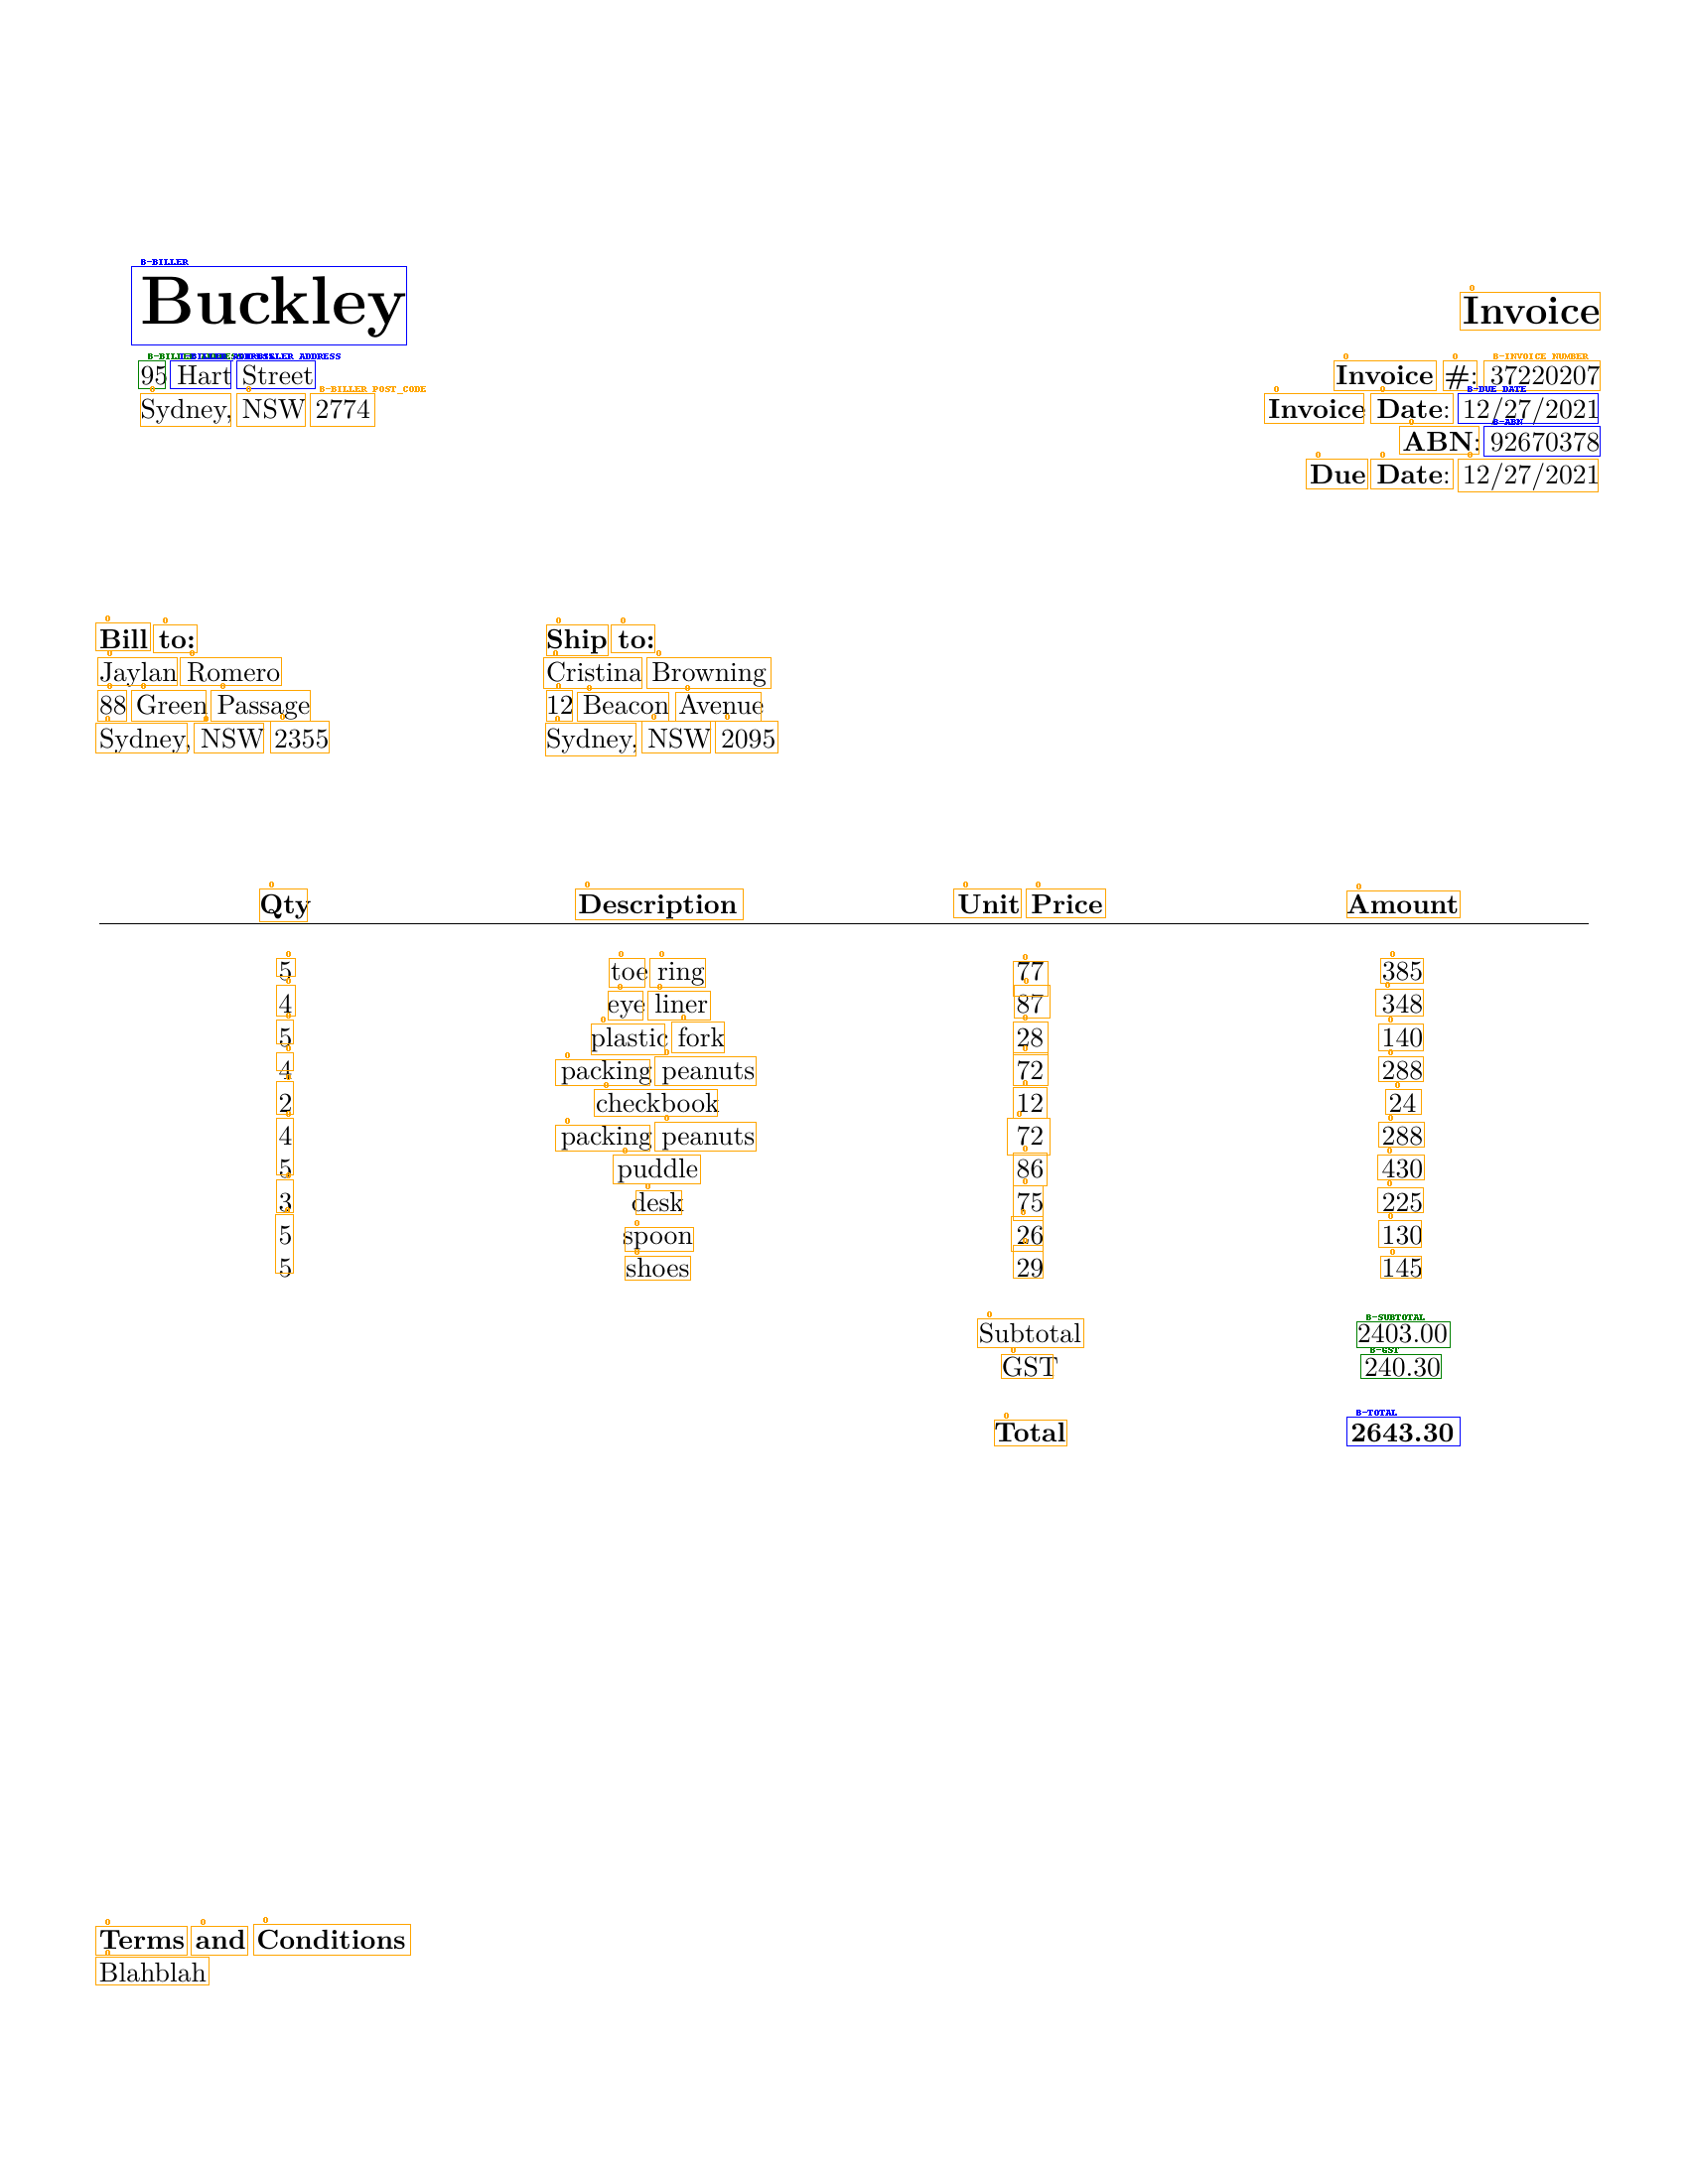

In [34]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    #label = label[2:]
    if not label:
      return 'other'
    return label

label2color ={
    "B-ABN": 'blue',
    "B-BILLER": 'blue',
    "B-BILLER_ADDRESS": 'green',
    "B-BILLER_POST_CODE": 'orange',
    "B-DUE_DATE": "blue",
    "B-GST": 'green',
    "B-INVOICE_DATE": 'violet',
    "B-INVOICE_NUMBER": 'orange',
    "B-SUBTOTAL": 'green',
    "B-TOTAL": 'blue',
    "I-BILLER_ADDRESS": 'blue',
    "O": 'orange'
  } 

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction)
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

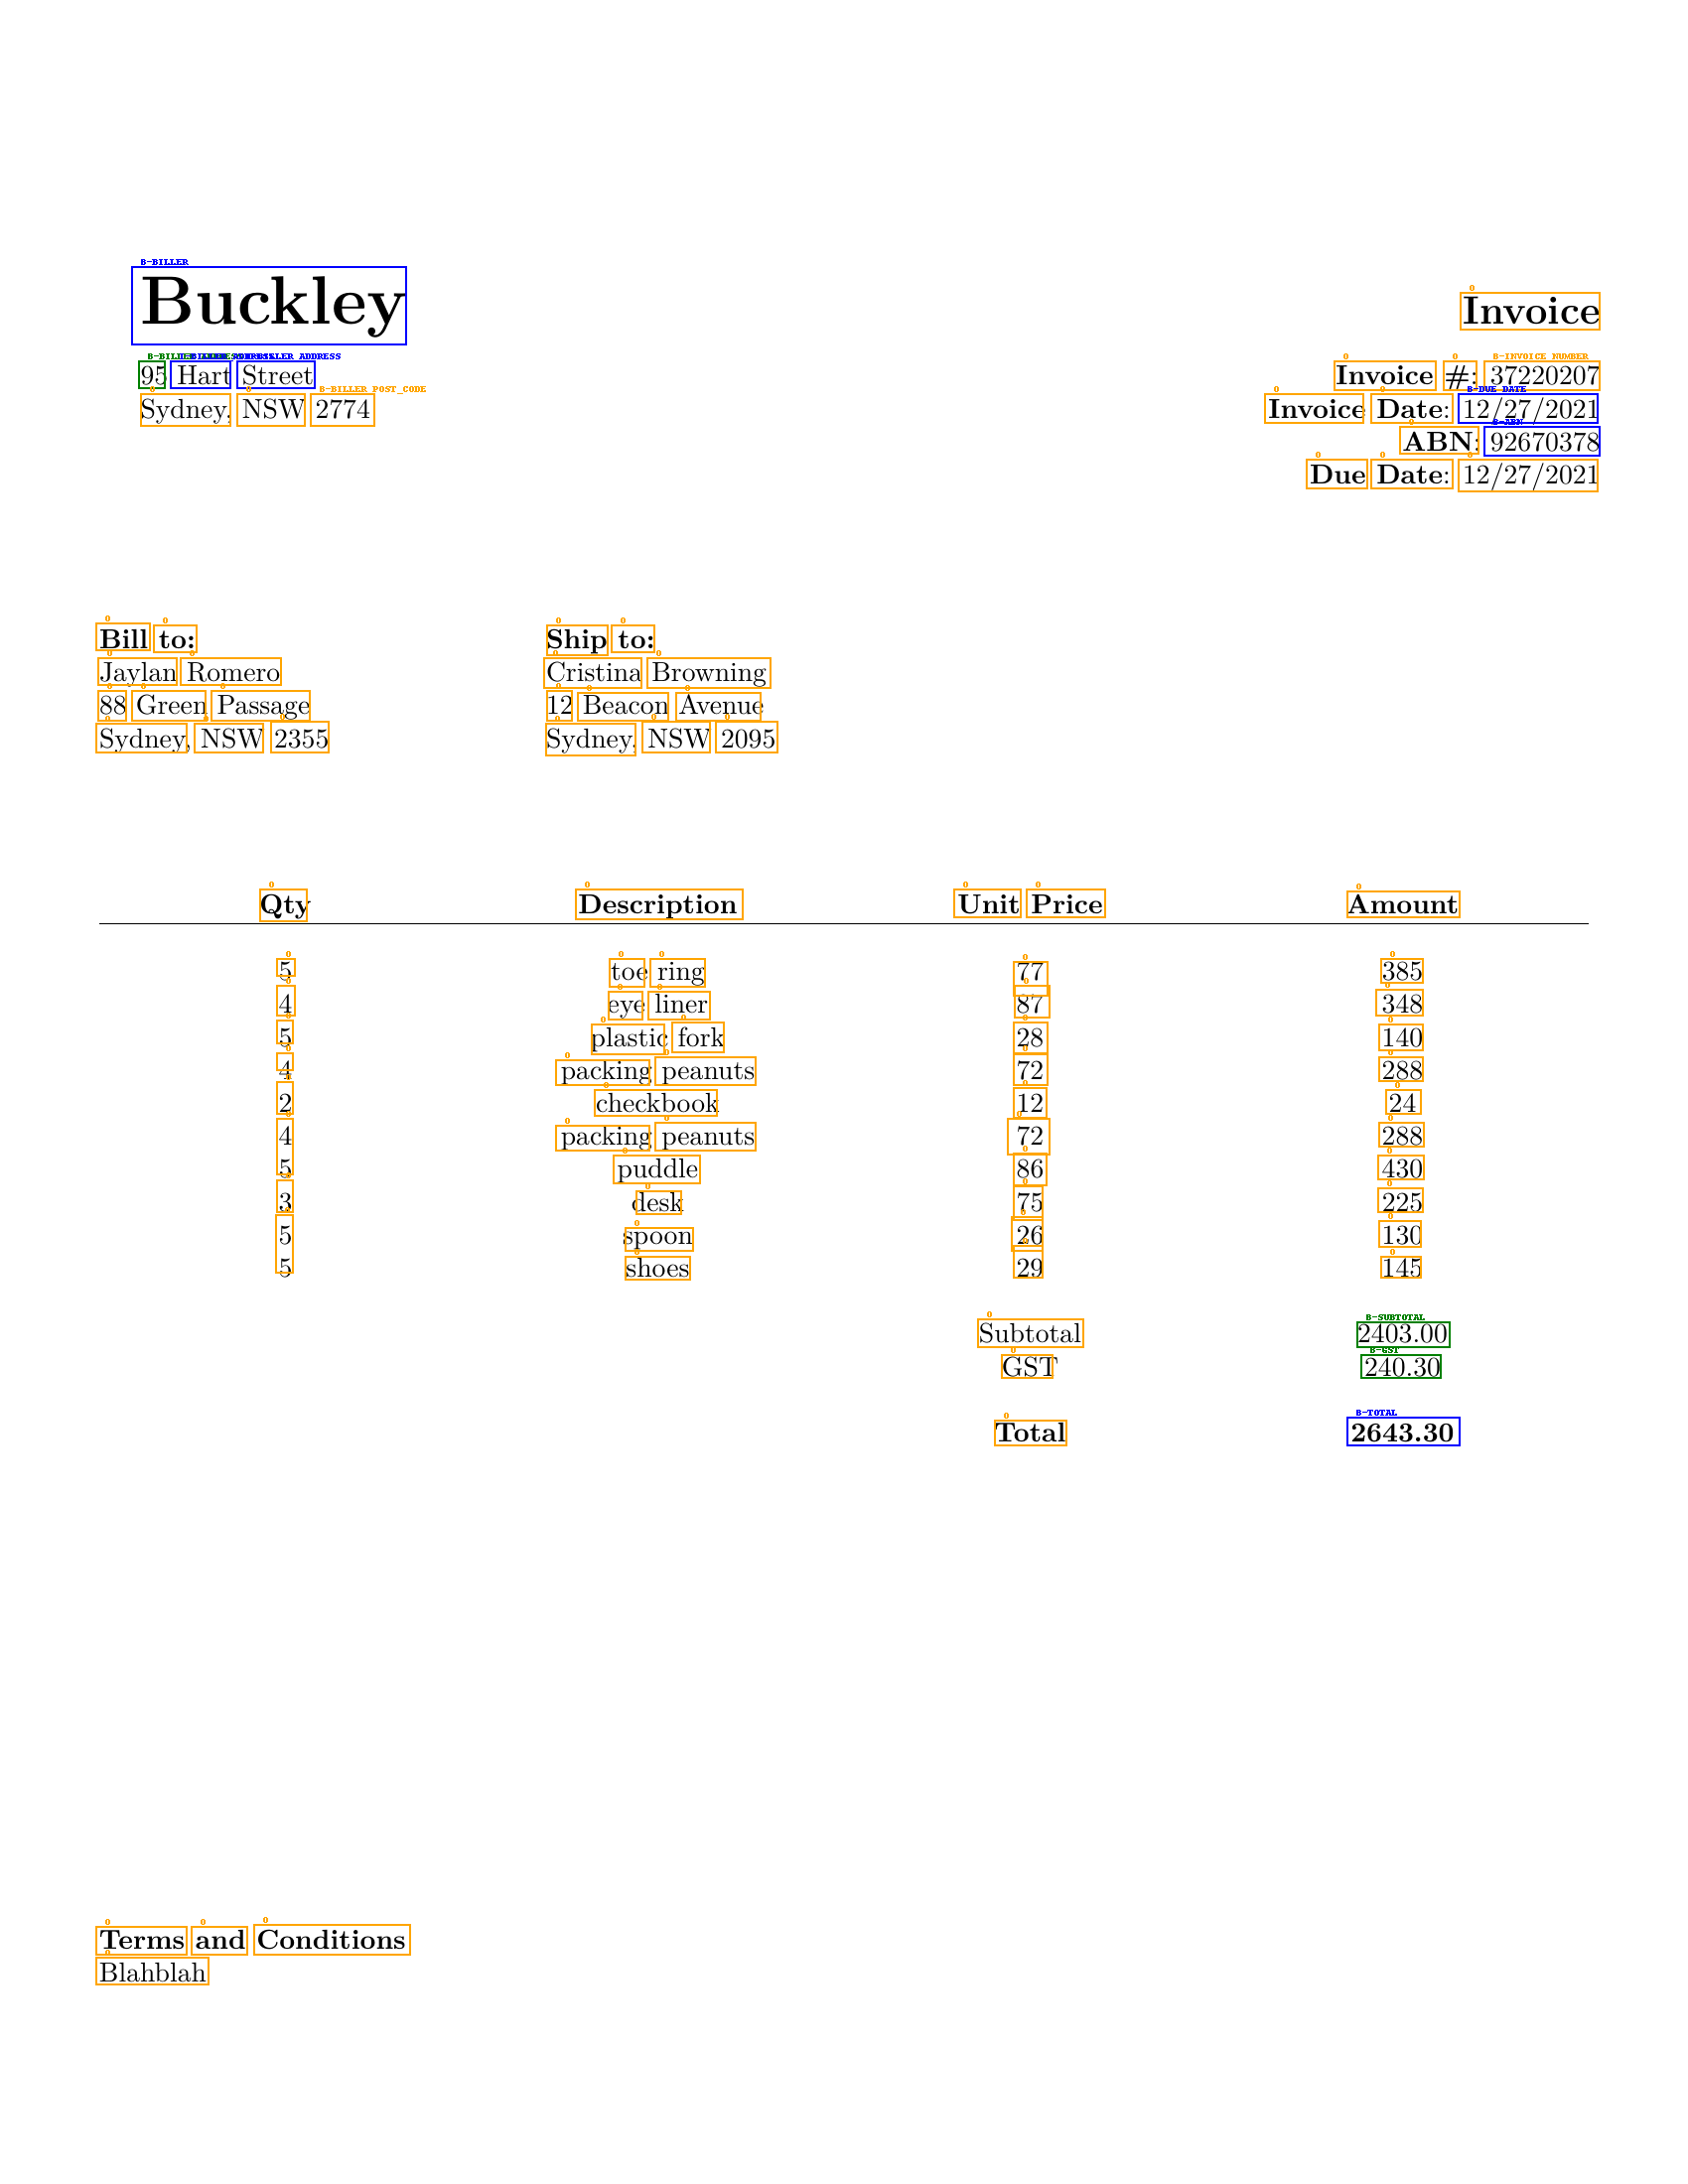

In [35]:
image = Image.open(example["image_path"]).convert("RGB")

draw = ImageDraw.Draw(image)

for word, box, label in zip(example['words'], example['bboxes'], example['ner_tags']):
  actual_label = iob_to_label(id2label[label])
  box = unnormalize_box(box, width, height)
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image

# Inference

In [3]:
import os

import gradio as gr
import numpy as np
from transformers import AutoModelForTokenClassification
from datasets.features import ClassLabel
from transformers import AutoProcessor
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D
import torch
from datasets import load_metric
from transformers import LayoutLMv3ForTokenClassification
from transformers.data.data_collator import default_data_collator


from transformers import AutoModelForTokenClassification
from datasets import load_dataset
from PIL import Image, ImageDraw, ImageFont


processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=True)
model = AutoModelForTokenClassification.from_pretrained("layoutlmv3-finetuned-invoice")



# load image example
dataset = load_dataset("darentang/generated", split="test")
Image.open(dataset[2]["image_path"]).convert("RGB").save("example1.png")
Image.open(dataset[1]["image_path"]).convert("RGB").save("example2.png")
Image.open(dataset[0]["image_path"]).convert("RGB").save("example3.png")
# define id2label, label2color
labels = dataset.features['ner_tags'].feature.names
id2label = {v: k for v, k in enumerate(labels)}
label2color = {
    "B-ABN": 'blue',
    "B-BILLER": 'blue',
    "B-BILLER_ADDRESS": 'green',
    "B-BILLER_POST_CODE": 'orange',
    "B-DUE_DATE": "blue",
    "B-GST": 'green',
    "B-INVOICE_DATE": 'violet',
    "B-INVOICE_NUMBER": 'orange',
    "B-SUBTOTAL": 'green',
    "B-TOTAL": 'blue',
    "I-BILLER_ADDRESS": 'blue',
    "O": 'orange'
  } 

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]


def iob_to_label(label):
    return label



def process_image(image):

    print(type(image))
    width, height = image.size

    # encode
    encoding = processor(image, truncation=True, return_offsets_mapping=True, return_tensors="pt")
    offset_mapping = encoding.pop('offset_mapping')

    # forward pass
    outputs = model(**encoding)

    # get predictions
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    token_boxes = encoding.bbox.squeeze().tolist()

    # only keep non-subword predictions
    is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0
    true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
    true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(true_predictions, true_boxes):
        predicted_label = iob_to_label(prediction)
        draw.rectangle(box, outline=label2color[predicted_label])
        draw.text((box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font)
    
    return image


title = "Invoice Information extraction using LayoutLMv3 model"
description = "Invoice Information Extraction - We use Microsoft's LayoutLMv3 trained on Invoice Dataset to predict the Biller Name, Biller Address, Biller post_code, Due_date, GST, Invoice_date, Invoice_number, Subtotal and Total. To use it, simply upload an image or use the example image below. Results will show up in a few seconds."

article="<b>References</b><br>[1] Y. Xu et al., “LayoutLMv3: Pre-training for Document AI with Unified Text and Image Masking.” 2022. <a href='https://arxiv.org/abs/2204.08387'>Paper Link</a><br>[2]  <a href='https://github.com/NielsRogge/Transformers-Tutorials/tree/master/LayoutLMv3'>LayoutLMv3 training and inference</a>" 

examples =[['example1.png'],['example2.png'],['example3.png']]

css = """.output_image, .input_image {height: 600px !important}"""

iface = gr.Interface(fn=process_image, 
                     inputs=gr.inputs.Image(type="pil"), 
                     outputs=gr.outputs.Image(type="pil", label="annotated image"),
                     title=title,
                     description=description,
                     article=article,
                     examples=examples,
                     css=css,
                     analytics_enabled = True, enable_queue=True)

iface.launch(inline=False, share=True, debug=True)

Reusing dataset sroie (/root/.cache/huggingface/datasets/darentang___sroie/sroie/1.0.0/123b71a2458ee87350d19e618ac7f21ab14e82b21945aef589bd809d479edf43)
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `enable_queue` is deprecated in `Interface()`, please use it within `launch()` instead.
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://34470.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


<class 'PIL.Image.Image'>


/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:755: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning


<class 'PIL.Image.Image'>


/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:755: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning


Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7f7624fb8a90>,
 'http://127.0.0.1:7861/',
 'https://34470.gradio.app')